In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!unzip face-mask-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Medical mask/Medical mask/Medical Mask/images/1091.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1102.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1103.png  
  inflating: Medical mask/Medical mask/Medical Mask/images/1104.jpg  
  inflating: Medical mask/Medical mask/

In [4]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
directory = "/content/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/submission.csv")

In [7]:
!wget https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

--2026-01-07 16:12:46--  https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel [following]
--2026-01-07 16:12:46--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10666211 (10M) [application/octet-stream]
Saving to: ‘res10_300x300_ssd_iter_140000.caffem

In [8]:
# Assuming the files are downloaded and in the current directory:
cvNet = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [9]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '4135.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 299867968870935232,
   'BoundingBox': [95, 87, 240, 266],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 439839316188540544,
   'BoundingBox': [105, 160, 226, 259],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 542749523004050880,
   'BoundingBox': [97, 90, 240, 214],
   'classname': 'hat',
   'Confidence': 1,
   'Attributes': {}}]}

In [10]:
df = pd.read_csv("train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


<Axes: xlabel='count'>

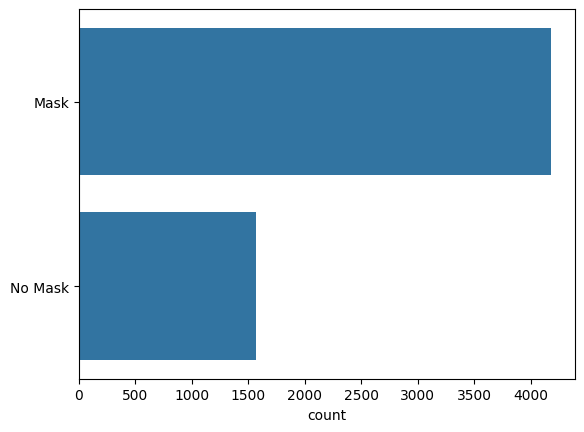

In [11]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [12]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)
datagen.fit(xtrain)

history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 241ms/step - accuracy: 0.8034 - loss: 0.5266 - val_accuracy: 0.9043 - val_loss: 0.2549
Epoch 2/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.8750 - loss: 0.2006

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8750 - loss: 0.2006 - val_accuracy: 0.9096 - val_loss: 0.2500
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.8862 - loss: 0.2728 - val_accuracy: 0.9104 - val_loss: 0.2107
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8750 - loss: 0.3199 - val_accuracy: 0.8948 - val_loss: 0.2295
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.9009 - loss: 0.2498 - val_accuracy: 0.9122 - val_loss: 0.2113
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9375 - loss: 0.4933 - val_accuracy: 0.9070 - val_loss: 0.2249
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.8940 - loss: 0.2627 - val_accuracy: 0.9322 - val_loss: 0.2034
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0886 - val_accuracy: 0.9296 - val_loss: 0.2055
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9091 - loss: 0.2322 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


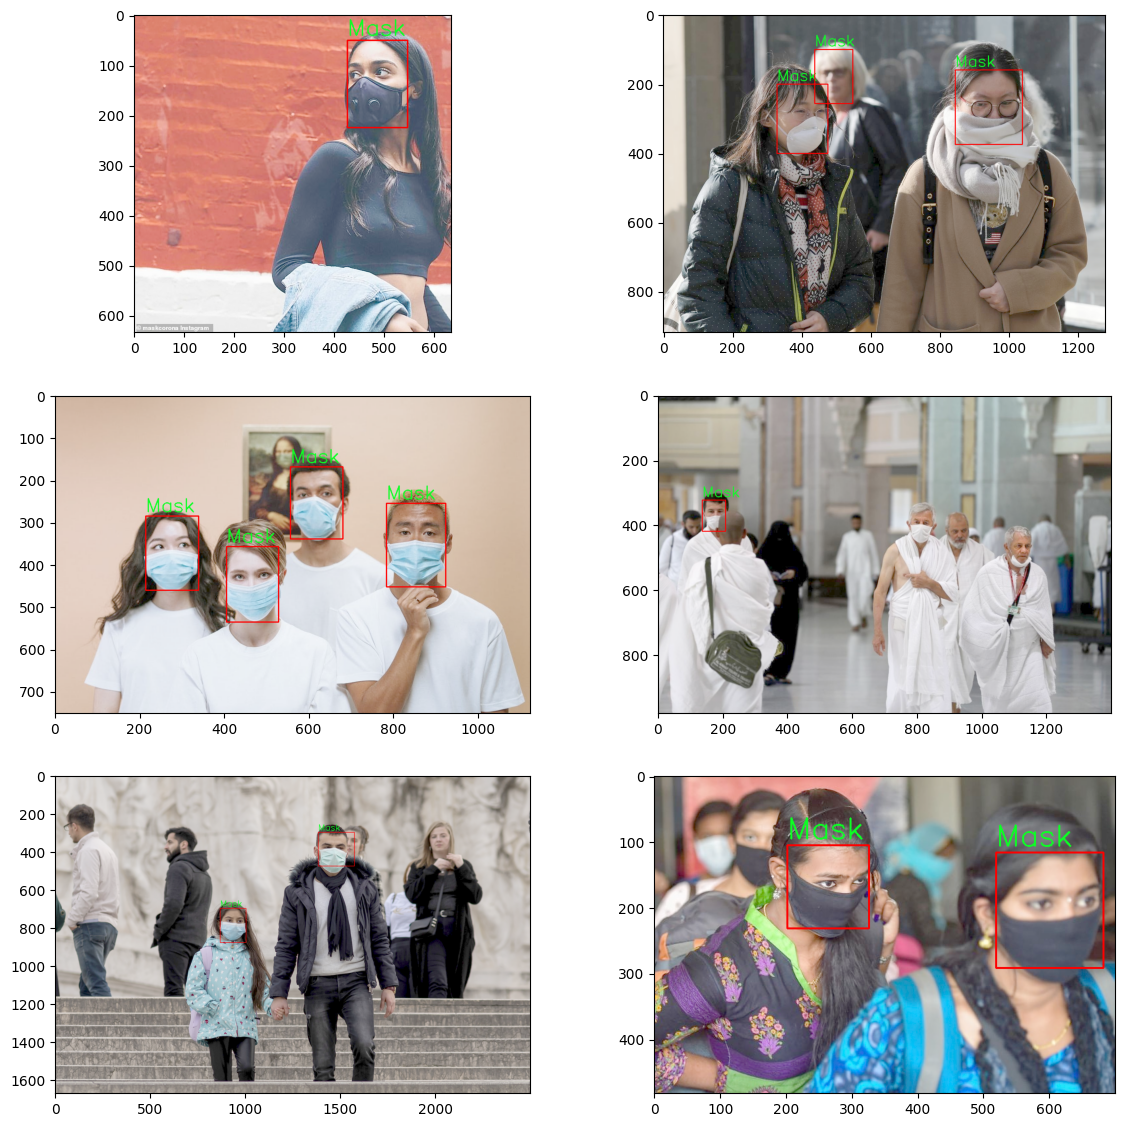

In [14]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)

        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()